## Install Requirements and Import Libraries

In [1]:
# Install requirements
! pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 5.0 MB/s eta 0:00:0000:01


In [2]:
# Import libraries
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [60]:
# Read cleaned data
df = pd.read_csv("../../data/curated/reviews/yiting_cleaned_reviews.csv")

# Display 5 random samples
df.sample(5)

,Sentiment,Time,Text,processed_text
2262,1,6/7/21,"Well, I am neither British, nor British-born, ...",well neither british british bear absolutely l...
4655,0,4/8/21,I did not know anything about chutney until I ...,know anything chutney know recipe cite find mi...
1679,1,1/3/20,I wasn't sure that we would be able to find a ...,sure would able find powdered milk family woul...
274,1,11/9/21,We have a 4 year old granddaughter and another...,year old granddaughter another grand baby way ...
4092,1,22/5/21,"My daughter loves the food, and I like it even...",daughter love food like even better organic am...


In [4]:
# Re-labelling of columns headers
df.rename(columns = {'Sentiment' : 'labels', 'processed_text' : 'text'}, inplace = True)

# Extracting out the necessary columns
df = df[['text','labels']]

# Display the current dataframe
df.head()

,text,labels
0,healthy dog food good digestion also good smal...,1
1,pleased natural balance dog food dog issue dog...,1
2,educate feline nutrition allow cat become addi...,1
3,holistic vet recommend along brand try cat pre...,1
4,buy coffee much cheaper ganocafe organic reish...,1


In [5]:
# Extract labels values to get the size
arr = df['labels'].values
arr.size

5444

In [6]:
# Creating 2D array to indicate which row of data the label belongs to
labels = np.zeros((arr.size, arr.max() + 1), dtype=int)
print(f"Label Shape: {labels.shape}")

# Indicating the label (0 or 1) of the respective row of data
## [1, 0] indicates negative sentiment
## [0, 1] indicates positive sentiment
labels[np.arange(arr.size), arr] = 1
print(f"Label Shape: {labels.shape}")

Label Shape: (5444, 2)
Label Shape: (5444, 2)


## BertTokenizer

In [7]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BERT tokenizer...


We need to check length of the encoded texts, which will allow us to pick a reasonable MAX_LEN. 

In [8]:
# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in df['text']]

# Find the maximum length
token_lens = [len(sent) for sent in encoded_tweets]
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors


Max length:  1208


/var/folders/hf/vxvn1cm55jncfc4dx4xp_q2h0000gn/T/ipykernel_30890/2976786349.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


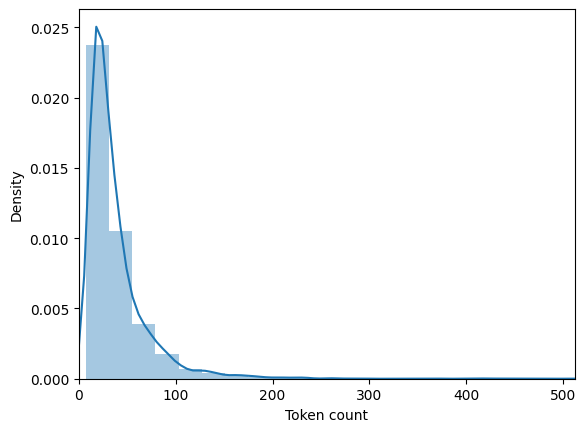

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

Some of the sentences in the text column are too long. When these sentences are converted to tokens and sent inside the model, they exceed the 512 seq_length limit of the model. This is a problem as the embedding of the model used in the sentiment-analysis task was trained on 512 tokens embedding.

To fix this issue we can either: 
 
1. Truncate the sentences with truncating = True

2. Filter out the long sentences and keep only smaller ones

```
sentiment = classifier(data.iloc[i,0], truncation=True)
```

## Preparing data inputs for the model

Using the first method (truncating = True) to combat the issue of long sentences.

Article: https://betterprogramming.pub/build-a-natural-language-classifier-with-bert-and-tensorflow-4770d4442d41

In [10]:
# Specify max seq length of the model
MAX_LEN = 150

In [11]:
# Initialise two arrays for input tensors
Xids = np.zeros((len(df), MAX_LEN))
Xmask = np.zeros((len(df), MAX_LEN))
Xids.shape

(5444, 512)

In [12]:
import tensorflow as tf
# For each text in the dataframe...
for i, sequence in enumerate(df['text']):
    
    # Return a dictionary containing the encoded sentence
    tokens = tokenizer.encode_plus(str(sequence), max_length = MAX_LEN, 
                                   truncation = True,               # Needed since there are text seq > 512
                                   padding = "max_length",          # For sentence < 512, padding is applied to reach a length of 512
                                   add_special_tokens = True,       # Mark the start and end of sequences
                                   return_token_type_ids = False, 
                                   return_attention_mask = True, 
                                   return_tensors = 'tf')           # Return TensorFlow object
    
    # Retrieve input_ids and attention_mask
    ### input_ids : list of integers uniquely tied to a specific word
    ### attention_mask : binary tokens indicating which tokens are the actual input tokens and which are padding tokens
    Xids[i, :], Xmask[i, :] = tokens['input_ids'], tokens['attention_mask']

2023-03-31 18:51:54.143877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 18:52:02.137279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
Xids

array([[  101.,  7965.,  3899., ...,     0.,     0.,     0.],
       [  101.,  7537.,  3019., ...,     0.,     0.,     0.],
       [  101., 16957., 10768., ...,     0.,     0.,     0.],
       ...,
       [  101.,  4067.,  2643., ...,     0.,     0.,     0.],
       [  101.,  4031.,  2204., ...,     0.,     0.,     0.],
       [  101., 11498.,  7446., ...,     0.,     0.,     0.]])

In [14]:
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [15]:
# Combine arrays into tensorflow object
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

# Display one training example
for i in dataset.take(1):
    print(i)

(<tf.Tensor: shape=(512,), dtype=float64, numpy=
array([  101.,  7965.,  3899.,  2833.,  2204., 17886.,  3258.,  2036.,
        2204.,  2235., 17022.,  3899., 20323.,  5478.,  3815.,  2296.,
        8521.,   102.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0

In [16]:
# Create function to restructure the dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks},labels

# Apply map method to apply our function above to the dataset
dataset = dataset.map(map_func)
for i in dataset.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(512,), dtype=float64, numpy=
array([  101.,  7965.,  3899.,  2833.,  2204., 17886.,  3258.,  2036.,
        2204.,  2235., 17022.,  3899., 20323.,  5478.,  3815.,  2296.,
        8521.,   102.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,

In [17]:
# Shuffle the data to prevent overfitting
dataset = dataset.shuffle(100000, reshuffle_each_iteration = False)

# Display one training example
for i in dataset.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(512,), dtype=float64, numpy=
array([  101.,  2307.,  2126.,  4845.,  2131., 10962.,  2310., 13871.,
        2666.,  5587., 10930., 27390.,  2102.,  5744.,  2100.,   102.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,

In [18]:
# Obtain length of dataset
DS_LEN = len(list(dataset))
DS_LEN

5444

## Splitting into train, test and validation set

In [19]:
# Specify test-train split
SPLIT = .8

# Take or skip the specified number of batches to split by factor
test = dataset.skip(round(DS_LEN * SPLIT)).batch(32)
trainevalu = dataset.take(round(DS_LEN * SPLIT)) # 282

DS_LEN2 = len(list(trainevalu))

train = trainevalu.take(round(DS_LEN2 * SPLIT)).batch(32)
evalu = trainevalu.skip(round(DS_LEN2 * SPLIT)).batch(32)

# Uncomment the code below to delete dataset and free up disk space
# del dataset

In [20]:
print(f"Test data: {len(test)}")
print(f"Train data: {len(train)}")
print(f"Train evaluation data: {len(evalu)}")

Test data: 35
Train data: 109
Train evaluation data: 28


## Model

In [21]:
from transformers import BertConfig

# Initialise BERT Model
bertConfig = BertConfig.from_pretrained('bert-base-uncased', 
                                        output_hidden_states = True,
                                        num_labels = 2,
                                        max_length = MAX_LEN
                                        )

In [22]:
from transformers import TFBertForSequenceClassification

tranformersPreTrainedModelName = 'bert-base-uncased'
bert = TFBertForSequenceClassification.from_pretrained(tranformersPreTrainedModelName, config = bertConfig)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Build 2 input layers to Bert Model where name needs to match the input values in the dataset
input_ids = tf.keras.Input(shape = (MAX_LEN, ), name = 'input_ids', dtype = 'int32')
mask = tf.keras.Input(shape = (MAX_LEN, ), name = 'attention_mask', dtype = 'int32')

# Consume the last_hidden_state from BERT
embedings = bert.layers[0](input_ids, attention_mask=mask)[0]

# Original Author: Ferry Djaja
# https://djajafer.medium.com/multi-class-text-classification-with-keras-and-lstm-4c5525bef592
X = tf.keras.layers.Flatten()(embedings)
X = tf.keras.layers.Dropout(0.5)(X)
y = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(X)

model = tf.keras.Model(inputs=[input_ids,mask], outputs=y)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [24]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
# loss = tf.keras.losses.CategoricalCrossentropy()
# acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

# model.compile(optimizer=optimizer, loss=loss, metrics=[acc, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [25]:
# history = model.fit(train, validation_data = evalu, epochs = 2, shuffle=True)

tf.keras.models.save_model(model, 'SA')

In [26]:
# loaded_model = tf.keras.models.load_model("../../model/BERT_SA")


## Obtaining best model metrics with callbacks

Model Checkpoint: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

Early Stopping: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

Use learning rate scheduler to get decaying learning rate

Learning Rate Scheduler: https://huggingface.co/course/chapter3/3?fw=tf

In [27]:
BATCH_SIZE = 32
EPOCHS = 10

num_train_steps = len(train)*EPOCHS
print(num_train_steps)

1090


In [28]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

# Produce a decayed learning rate
lr_scheduler = PolynomialDecay(initial_learning_rate = 5e-5, end_learning_rate = 2e-5, decay_steps = num_train_steps)
opt = tf.keras.optimizers.Adam(learning_rate = lr_scheduler)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=opt, loss=loss, metrics=[acc, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [29]:
# Directory and File path name to store checkpoints
checkpoint_dir = 'tmp'
checkpoint_filepath = 'tmp/checkpoint.hdf5'

# Create file path to store the checkpoints
## If a directory has already been created, comment out the code
os.makedirs(checkpoint_dir)

In [30]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3 # Stop training when there is no improvement in the loss after 3 consecutive epochs
)

In [31]:
history_callback = model.fit(train, validation_data = evalu, 
    epochs = EPOCHS, shuffle = True, 
    callbacks = [model_checkpoint_callback, early_stopping_callback])

Epoch 1/10


KeyboardInterrupt: 

In [ ]:
# The model weights (that are considered the best) are loaded into the model
model.load_weights(checkpoint_filepath)

# Compile the model again to prepare for prediction
model.compile(optimizer=opt, loss=loss, metrics=[acc, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# Run the model on the test data
predicted = model.predict(test)
y_predicted = np.argmax(predicted, axis = 1)

# Retrieve true labels for test set
test_true_labels = tf.concat([y for x, y in test], axis = 0)

In [ ]:
# Accuracy of test data
model.evaluate(test)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_predicted, test_true_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['negative', 'positive'])
cm_display.plot()

## Preparing data inputs for the model (2)

Using the second method (filter) to combat the issue of long sentences.

In [ ]:
# Obtain indexes of encoded sentences that have length <= 150
indexes = [i for i,v in enumerate(token_lens) if v <= 150]

In [ ]:
# Keep only relevant encoded sentences
df_filter = df.iloc[indexes]

# Display 5 random samples
df_filter.sample(5)

In [ ]:
# Extract labels values to get the size
arr_filter = df_filter['labels'].values
arr_filter.size

# Creating 2D array to indicate which row of data the label belongs to
labels_filter = np.zeros((arr_filter.size, arr_filter.max() + 1), dtype=int)
print(f"Label Shape: {labels_filter.shape}")

# Indicating the label (0 or 1) of the respective row of data
labels_filter[np.arange(arr_filter.size), arr_filter] = 1
print(f"Label Shape: {labels_filter.shape}")

# Specify max seq length of the model
MAX_LEN = 150

Label Shape: (5357, 2)
Label Shape: (5357, 2)


In [ ]:
# Initialise two arrays for input tensors
Xids_filter = np.zeros((len(df_filter), MAX_LEN))
Xmask_filter = np.zeros((len(df_filter), MAX_LEN))
Xids_filter.shape

(5357, 150)

In [ ]:
import tensorflow as tf

# For each text in the dataframe...
for i, sequence in enumerate(df_filter['text']):
    
    # Return a dictionary containing the encoded sentence
    tokens = tokenizer.encode_plus(str(sequence), max_length = MAX_LEN, 
                                   truncation = False,              # Not needed since filtering was done
                                   padding = "max_length",          # For sentence < 512, padding is applied to reach a length of 512
                                   add_special_tokens = True,       # Mark the start and end of sequences
                                   return_token_type_ids = False, 
                                   return_attention_mask = True, 
                                   return_tensors = 'tf')           # Return TensorFlow object
    
    # Retrieve input_ids and attention_mask
    ### input_ids : list of integers uniquely tied to a specific word
    ### attention_mask : binary tokens indicating which tokens are the actual input tokens and which are padding tokens
    Xids_filter[i, :], Xmask_filter[i, :] = tokens['input_ids'], tokens['attention_mask']

In [ ]:
# Combine arrays into tensorflow object
dataset_filter = tf.data.Dataset.from_tensor_slices((Xids_filter, Xmask_filter, labels_filter))

# Display one training example
for i in dataset_filter.take(1):
    print(i)

(<tf.Tensor: shape=(150,), dtype=float64, numpy=
array([  101.,  7965.,  3899.,  2833.,  2204., 17886.,  3258.,  2036.,
        2204.,  2235., 17022.,  3899., 20323.,  5478.,  3815.,  2296.,
        8521.,   102.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0

In [ ]:
# Create function to restructure the dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks},labels

# Apply map method to apply our function above to the dataset
dataset_filter = dataset_filter.map(map_func)

for i in dataset_filter.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(150,), dtype=float64, numpy=
array([  101.,  7965.,  3899.,  2833.,  2204., 17886.,  3258.,  2036.,
        2204.,  2235., 17022.,  3899., 20323.,  5478.,  3815.,  2296.,
        8521.,   102.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,

In [ ]:
# Shuffle the data
dataset_filter = dataset_filter.shuffle(100000, reshuffle_each_iteration = False)

# Display one training example
for i in dataset_filter.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(150,), dtype=float64, numpy=
array([  101.,  2367.,  2785., 16324.,  2028.,  2600.,  2052.,  2196.,
        2113.,  1043.,  7630.,  6528.,  2489.,   102.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,

In [ ]:
# Obtain length of dataset
DS_LEN = len(list(dataset_filter))
DS_LEN

5357

In [ ]:
# Specify test-train split
SPLIT = .8

# Take or skip the specified number of batches to split by factor
test_filter = dataset_filter.skip(round(DS_LEN * SPLIT)).batch(32)
trainevalu_filter = dataset_filter.take(round(DS_LEN * SPLIT)) # 282

DS_LEN2 = len(list(trainevalu_filter))

train_filter = trainevalu_filter.take(round(DS_LEN2 * SPLIT)).batch(32)
evalu_filter = trainevalu_filter.skip(round(DS_LEN2 * SPLIT)).batch(32)

# Uncomment the code below to delete dataset and free up disk space
# del dataset

print(f"Test data: {len(test_filter)}")
print(f"Train data: {len(train_filter)}")
print(f"Train evaluation data: {len(evalu_filter)}")

Test data: 34
Train data: 108
Train evaluation data: 27


In [ ]:
from transformers import TFBertForSequenceClassification

tranformersPreTrainedModelName = 'bert-base-uncased'
bert = TFBertForSequenceClassification.from_pretrained(tranformersPreTrainedModelName, config = bertConfig)

# Build 2 input layers to Bert Model where name needs to match the input values in the dataset
input_ids = tf.keras.Input(shape = (MAX_LEN, ), name = 'input_ids', dtype = 'int32')
mask = tf.keras.Input(shape = (MAX_LEN, ), name = 'attention_mask', dtype = 'int32')

# Consume the last_hidden_state from BERT
embedings = bert.layers[0](input_ids, attention_mask=mask)[0]

# Original Author: Ferry Djaja
# https://djajafer.medium.com/multi-class-text-classification-with-keras-and-lstm-4c5525bef592
X = tf.keras.layers.Flatten()(embedings)
X = tf.keras.layers.Dropout(0.5)(X)
y = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(X)

model_filter = tf.keras.Model(inputs=[input_ids,mask], outputs=y)
model_filter.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 150)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 150)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 150,                                           

## Obtaining best model metrics with callbacks (2)

Model Checkpoint: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

Early Stopping: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

Use learning rate scheduler to get decaying learning rate

Learning Rate Scheduler: https://huggingface.co/course/chapter3/3?fw=tf

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

num_train_steps = len(train_filter)*EPOCHS
print(num_train_steps)

In [ ]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

# Produce a decayed learning rate
lr_scheduler = PolynomialDecay(initial_learning_rate = 5e-5, end_learning_rate = 2e-5, decay_steps = num_train_steps)
opt = tf.keras.optimizers.Adam(learning_rate = lr_scheduler)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model_filter.compile(optimizer=opt, loss=loss, metrics=[acc, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# File path to store metrics during checkpoints
checkpoint_filepath_filter = 'tmp/filter_checkpoint.hdf5'

In [ ]:
model_filter_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath_filter,
    save_weights_only = True,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)

early_stopping_filter_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3 # Stop training when there is no improvement in the loss after 3 consecutive epochs
)

In [ ]:
history_filter_callback = model_filter.fit(train_filter, validation_data = evalu_filter, 
    epochs = EPOCHS, shuffle = True, 
    callbacks = [model_filter_checkpoint_callback, early_stopping_filter_callback])

In [ ]:
# The model weights (that are considered the best) are loaded into the model
model_filter.load_weights(checkpoint_filepath_filter)

# Compile the model again to prepare for prediction
model_filter.compile(optimizer=opt, loss=loss, metrics=[acc, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# Run the model on the test data
predicted_filter = model_filter.predict(test_filter)

from sklearn.metrics import classification_report

# Get classification report
y_predicted_filter = np.argmax(predicted_filter, axis = 1)
print(classification_report(test_filter['labels'], y_predicted_filter))

In [ ]:
cm = confusion_matrix(test_filter['labels'], predicted_filter)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['negative', 'positive'])
cm_display.plot()

## Bert Pipeline

Function to convert raw data into input for BERT

In [ ]:
def bert_pipeline(raw_data, sentence_column, labels_column, max_len = 512):
    
    import numpy as np
    from transformers import BertTokenizer
    import tensorflow as tf

    # Extract out the necessary columns
    print("Extracting out necessary columns...")
    df = raw_data[[sentence_column, labels_column]]

    # Extract label values to get the size
    arr = df[labels_column].values
    print(f"Total number of rows = {arr.size}")

    # Create 2D array to indicate which row of data the label belongs to
    labels = np.zeros((arr.size, arr.max() + 1), dtype=int)

    # Indicate the label (0 or 1) of the respective row of data
    labels[np.arange(arr.size), arr] = 1
    print(f"Label Shape: {labels.shape}")

    # Load the BERT tokenizer
    print('Loading BERT tokenizer...')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    # Encode our concatenated data
    print("Tokenizing sentences...")
    encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in df[sentence_column]]

    # Initialise two arrays for input tensors
    print("Initialising arrays for input tensors...")
    Xids = np.zeros((len(df), max_len))
    Xmask = np.zeros((len(df), max_len))
    print(f"Input Tensors Shape: {Xids.shape}")

    print("Encoding sentences...")
    # For each text in the dataframe...
    for i, sequence in enumerate(df[sentence_column]):
        
        # Return a dictionary containing the encoded sentence
        tokens = tokenizer.encode_plus(str(sequence), max_length = max_len, 
                                    truncation = True,               # Needed since there are text seq > 512
                                    padding = "max_length",          # For sentence < 512, padding is applied to reach a length of 512
                                    add_special_tokens = True,       # Mark the start and end of sequences
                                    return_token_type_ids = False, 
                                    return_attention_mask = True, 
                                    return_tensors = 'tf')           # Return TensorFlow object
        
        # Retrieve input_ids and attention_mask
        ### input_ids : list of integers uniquely tied to a specific word
        ### attention_mask : binary tokens indicating which tokens are the actual input tokens and which are padding tokens
        Xids[i, :], Xmask[i, :] = tokens['input_ids'], tokens['attention_mask']

    # Combine arrays into tensorflow object
    print("Creating Tensoflow Dataset...")
    dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

    # Create function to restructure the dataset
    def map_func(input_ids, masks, labels):
        return {'input_ids': input_ids, 'attention_mask': masks},labels

    # Apply map method to apply our function above to the dataset
    dataset = dataset.map(map_func)

    # Shuffle the data to prevent overfitting
    print("Shuffling dataset...")
    dataset = dataset.shuffle(100000, reshuffle_each_iteration = False)

    print("Success! Data is ready modelling!")
    return dataset